# Tutorial: Non-Linear Parametrization of $\texttt{JKOnet}^\ast$ in Euclidean space

In this tutorial, we will recover the potential within a simplified framework in Euclidean space by utilizing the Non-Linear Parametrization of $\texttt{JKOnet}^\ast$. We will create trajectories to serve as training data, train a Multi-Layer Perceptron (MLP) to predict the potential, and visualize the outcomes.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, vmap
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from typing import Any, Callable, Sequence


## Step 1: Define the Multi-Layer Perceptron (MLP)
Here we define our MLP architecture using Flax's linen module.


In [2]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        x = inputs

        for i, feat in enumerate(self.features):
            x = nn.Dense(feat, name=f'layers_{i}')(x)
            if i != len(self.features) - 1:
                x = nn.softmax(x)
           
        return x

## Step 2: Define the Real Potential Function and Its Gradient
We define the real potential function and compute its gradient with the autograd feature of JAX.

In [3]:
def V_real(x):
    return 10*jnp.sin(x)-x**2

grad_V_real = grad(V_real) # Derivative with respect to x

## Step 3: Generate Training Data Function
This function generates trajectories by following the gradient of the potential according to the explicit scheme
$$
x_{t+1} = x_{t} - \tau \nabla V(x_{t}, t).
$$

In [4]:
def generate_trajectories(
    potential: Callable[[jnp.ndarray], jnp.ndarray], 
    initial_conditions: jnp.ndarray, 
    t_values: jnp.ndarray, 
    tau: float
) -> jnp.ndarray:
    
    """Generate trajectories based on the potential function.
    
    Args:
        potential (Callable[[jnp.ndarray], jnp.ndarray]): The potential function.
        initial_conditions (jnp.ndarray): Initial conditions for trajectories.
        t_values (jnp.ndarray): Time values for the trajectories.
        tau (float): Time step size.

    Returns:
        jnp.ndarray: Generated trajectories.
    """
    num_trajectories = len(initial_conditions)
    timesteps = len(t_values)
    trajectories = jnp.zeros((num_trajectories, timesteps))
    trajectories = trajectories.at[:, 0].set(initial_conditions)

    for i in range(1, timesteps):
        x_prev = trajectories[:, i - 1]
        grad_x = vmap(lambda x: grad(potential, argnums=0)(x))(x_prev)
        x_next = x_prev - tau * grad_x
        trajectories = trajectories.at[:, i].set(x_next)

    return trajectories


## Step 4: Initialize Parameters and Generate Data
We initialize the random key, set parameters for the trajectories used as training data, and generate the data. The subsampling parameter allos to limit the amount of time steps used in training. Finally, we concatenate all the data of all the trajectories into a single batch.

In [20]:
# Initialize multiple trajectories to generate training data
key = random.PRNGKey(42)
num_trajectories = 20
timesteps = 101
x_initials = random.uniform(key, (num_trajectories,), minval=0.7, maxval=1.3)  # Initial values for each trajectory
t_values = jnp.linspace(0, 1, timesteps)
tau = t_values[1] - t_values[0] #Time step

# Generate trajectories
x_trajectories = generate_trajectories(V_real, x_initials, t_values, tau)
subsampling = 1 #Subsampling 1 means no subsampling

#We limit the amount of time steps we use to train
x_trajectories_sub = jnp.array([trajectory[::subsampling] for trajectory in x_trajectories])
t_values_sub = t_values[::subsampling]

# Prepare training data
#We create pairs of values where "x" represents the position at time "t", and "y" represents the position at time "t+1"
y_batch = x_trajectories_sub[:, 1:]  
x_batch = x_trajectories_sub[:, :-1]  

# Concatenate all trajectories into single batches
x_concatenated = jnp.concatenate(x_batch)
y_concatenated = jnp.concatenate(y_batch)

## Step 5: Initialize Model and Optimizer
We define the model architecture and initialize the optimizer.

In [21]:
# Initialize model and optimizer
input_shape = (1,)
features = [20, 20, 1] 
learning_rate = 0.05
num_epochs = 3000

model = MLP(features)
params = model.init(key, jnp.ones(input_shape))
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

## Step 6: Define the Loss Function
We define the loss function for training the MLP. Additionally we define an auxiliar function which does the same as model.apply but that returns a scalar. This will be necessary to later on use the autograd feature on the predicted potential. The loss function is defined as:
$$
L = \sum_{t=0}^{T-1} \left\| \nabla V(x_{t+1}) + \frac{1}{\tau}(x_{t+1} - x_t) \right\|^2
$$


In [22]:
def aux_fun(params: Any, x: jnp.ndarray) -> jnp.ndarray:
    """Auxiliary function for MLP to return a scalar.
    
    Args:
        params (Any): Parameters of the MLP.
        x (jnp.ndarray): Input data.

    Returns:
        jnp.ndarray: Output of the MLP.
    """
    x = x[:, None]  # This reshapes x to (N, 1) from (N,)
    return model.apply(params, x).squeeze()

#Gradient of the predicted potential with respect to x
grad_model = grad(aux_fun, argnums=1)

def mlp_loss(params: Any, x: jnp.ndarray, y: jnp.ndarray) -> float:
    """Calculate the loss.
    
    Args:
        params (Any): Parameters of the MLP.
        x (jnp.ndarray): Input data.
        y (jnp.ndarray): Target data.

    Returns:
        float: Computed loss value.
    """
    x = x[:, None]  # Shape (N, 1)
    y = y[:, None]  # Shape (N, 1)
    return jnp.mean(jnp.square(y - x + tau * vmap(grad_model, in_axes=(None, 0))(params, y)))


## Step 7: Training Loop
We train the model using the defined loss function and optimizer.

In [23]:
# Training loop
for epoch in range(num_epochs):
    loss, grads = jax.value_and_grad(mlp_loss)(params, x_concatenated, y_concatenated)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 0.0020409482531249523
Epoch 100, Loss: 0.0002842122339643538
Epoch 200, Loss: 1.8072743841912597e-05
Epoch 300, Loss: 4.800336682819761e-06
Epoch 400, Loss: 3.4892545954789966e-06
Epoch 500, Loss: 2.858977723008138e-06
Epoch 600, Loss: 2.427962272122386e-06
Epoch 700, Loss: 2.1667151486326475e-06
Epoch 800, Loss: 1.947805685631465e-06
Epoch 900, Loss: 1.5765109537824173e-06
Epoch 1000, Loss: 1.3494030781657784e-06
Epoch 1100, Loss: 1.1609155308178742e-06
Epoch 1200, Loss: 1.0283368965247064e-06
Epoch 1300, Loss: 9.378185836794728e-07
Epoch 1400, Loss: 8.70295082222583e-07
Epoch 1500, Loss: 8.211919748646324e-07
Epoch 1600, Loss: 8.940511975197296e-07
Epoch 1700, Loss: 7.51565153223055e-07
Epoch 1800, Loss: 7.741830927443516e-07
Epoch 1900, Loss: 6.963891792111099e-07
Epoch 2000, Loss: 7.065136742312461e-07
Epoch 2100, Loss: 6.510546768367931e-07
Epoch 2200, Loss: 7.752290684948093e-07
Epoch 2300, Loss: 6.128497602730931e-07
Epoch 2400, Loss: 5.938518370385282e-07
Epoch 2

## Step 8: Generate Predicted Trajectories
This function generates predicted trajectories using the trained model.

In [24]:
def generate_pred_trajectories_explicit(
    potential: Callable[[Any, jnp.ndarray], jnp.ndarray], 
    params: Any, 
    x_initials: jnp.ndarray, 
    t_values: jnp.ndarray, 
    tau: float
) -> jnp.ndarray:
    """Generate predicted trajectories based on learned parameters.
    
    Args:
        potential (Callable[[Any, jnp.ndarray], jnp.ndarray]): The potential function.
        params (Any): Parameters of the model.
        x_initials (jnp.ndarray): Initial conditions for predictions.
        t_values (jnp.ndarray): Time values for predictions.
        tau (float): Time step size.

    Returns:
        jnp.ndarray: Predicted trajectories.
    """
    num_trajectories = len(x_initials)
    num_timesteps = len(t_values)
    
    x_learned_trajectories = jnp.zeros((num_trajectories, num_timesteps))
    x_learned_trajectories = x_learned_trajectories.at[:, 0].set(x_initials)
    
    for i in range(1, num_timesteps):
        for j in range(num_trajectories):
            x_prev = x_learned_trajectories[j, i - 1]
            x_prev_reshaped = x_prev.reshape(1, 1)
            grad_x = grad(lambda x: potential(params, x))(x_prev_reshaped).squeeze()
            x_next = x_prev - tau * grad_x
            x_learned_trajectories = x_learned_trajectories.at[j, i].set(x_next)
        
    return x_learned_trajectories

# Prepare initial conditions for predictions
x_initial = x_trajectories_sub[:10][:, 0]
trajectories_pred = generate_pred_trajectories_explicit(aux_fun, params, x_initial, t_values_sub, tau)

## Step 9: Plotting the results
We plot the learned and real trajectories to visualize the performance of our model.

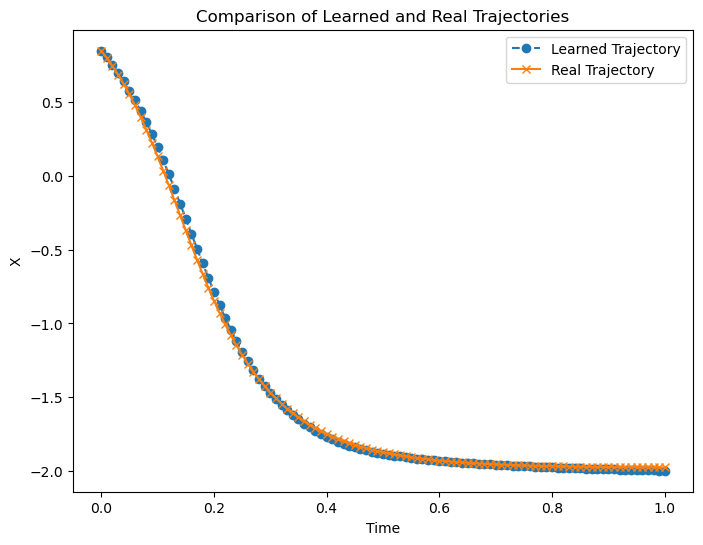

In [25]:
# Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(t_values_sub, trajectories_pred[0], label='Learned Trajectory', linestyle='--', marker='o')
plt.plot(t_values, x_trajectories[0], label='Real Trajectory', linestyle='-', marker='x')
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Comparison of Learned and Real Trajectories')
plt.legend()
# plt.savefig(f"implicit_explicit_{timesteps}_nosub.png")
plt.show()

# np.savetxt('traj_pred.txt', np.column_stack(
#             (t_values_sub, trajectories_pred[:10].T)), fmt='%-7.4f')
# 
# np.savetxt('traj_real.txt', np.column_stack(
#                 (t_values, x_trajectories[:10].T)), fmt='%-7.4f')

(10, 101) (101,)
Epoch 0, Loss: 0.002041643252596259
Epoch 100, Loss: 0.00028505458612926304
Epoch 200, Loss: 1.8227507098345086e-05
Epoch 300, Loss: 4.655907559936168e-06
Epoch 400, Loss: 3.284639888079255e-06
Epoch 500, Loss: 2.6084746878041187e-06
Epoch 600, Loss: 2.2114011244411813e-06
Epoch 700, Loss: 1.8721191281656502e-06
Epoch 800, Loss: 1.6495371255587088e-06
Epoch 900, Loss: 1.4789926581215695e-06
Epoch 1000, Loss: 1.3248541108623613e-06
Epoch 1100, Loss: 1.1996369266853435e-06
Epoch 1200, Loss: 1.0730010444603977e-06
Epoch 1300, Loss: 9.553418749419507e-07
Epoch 1400, Loss: 8.686788532941137e-07
Epoch 1500, Loss: 7.900503078417387e-07
Epoch 1600, Loss: 7.236353667394724e-07
Epoch 1700, Loss: 6.978220881137531e-07
Epoch 1800, Loss: 6.379374326570542e-07
Epoch 1900, Loss: 8.83885604707757e-07
Epoch 2000, Loss: 5.776237230747938e-07
Epoch 2100, Loss: 5.550492119255068e-07
Epoch 2200, Loss: 5.538689720196999e-07
Epoch 2300, Loss: 5.635848765450646e-07
Epoch 2400, Loss: 5.6981065

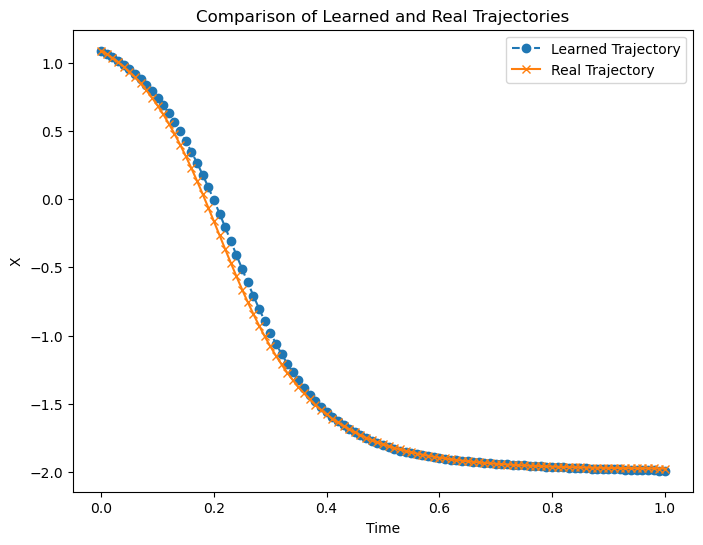